<a href="https://colab.research.google.com/github/Srividhya-coder/Demo/blob/main/earthquake_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earthquake Prediction

In [4]:
!pip install geopandas
!pip install catboost
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
filepath = './earthquakes.csv'

In [6]:
df = pd.read_csv(filepath)
df = df[df.mag.notna()]
df.time = pd.to_datetime(df.time)
df = df[::-1]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
35244,2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
35243,2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
35242,2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
35241,2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,NaN,NaN,NaN,0.21,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
35240,2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [7]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35244.000000,35244.000000,35244.000000,35244.000000,28038.000000,29241.000000,24218.000000,35244.000000,24989.000000,35244.000000,26445.000000,27361.000000
mean,37.167249,-108.586930,21.478567,1.663011,23.384443,116.452087,0.816648,0.275342,1.929334,4.240669,0.252210,17.163664
std,19.093721,67.752118,54.360684,1.311471,21.687801,60.420181,2.755295,0.272877,3.300874,389.384796,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.419542,-149.703350,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059583,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.512008,-113.777417,14.560000,2.110000,29.000000,150.000000,0.165825,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35244 entries, 35244 to 0
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   time             35244 non-null  datetime64[ns, UTC]
 1   latitude         35244 non-null  float64            
 2   longitude        35244 non-null  float64            
 3   depth            35244 non-null  float64            
 4   mag              35244 non-null  float64            
 5   magType          35244 non-null  object             
 6   nst              28038 non-null  float64            
 7   gap              29241 non-null  float64            
 8   dmin             24218 non-null  float64            
 9   rms              35244 non-null  float64            
 10  net              35244 non-null  object             
 11  id               35244 non-null  object             
 12  updated          35244 non-null  object             
 13  place           

In [9]:
df.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8799
magNst              7883
status                 0
locationSource         0
magSource              0
dtype: int64

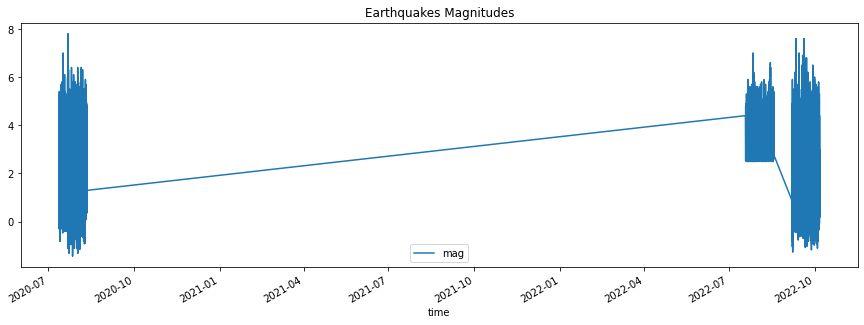

In [10]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', x='time', y='mag')
plt.show()

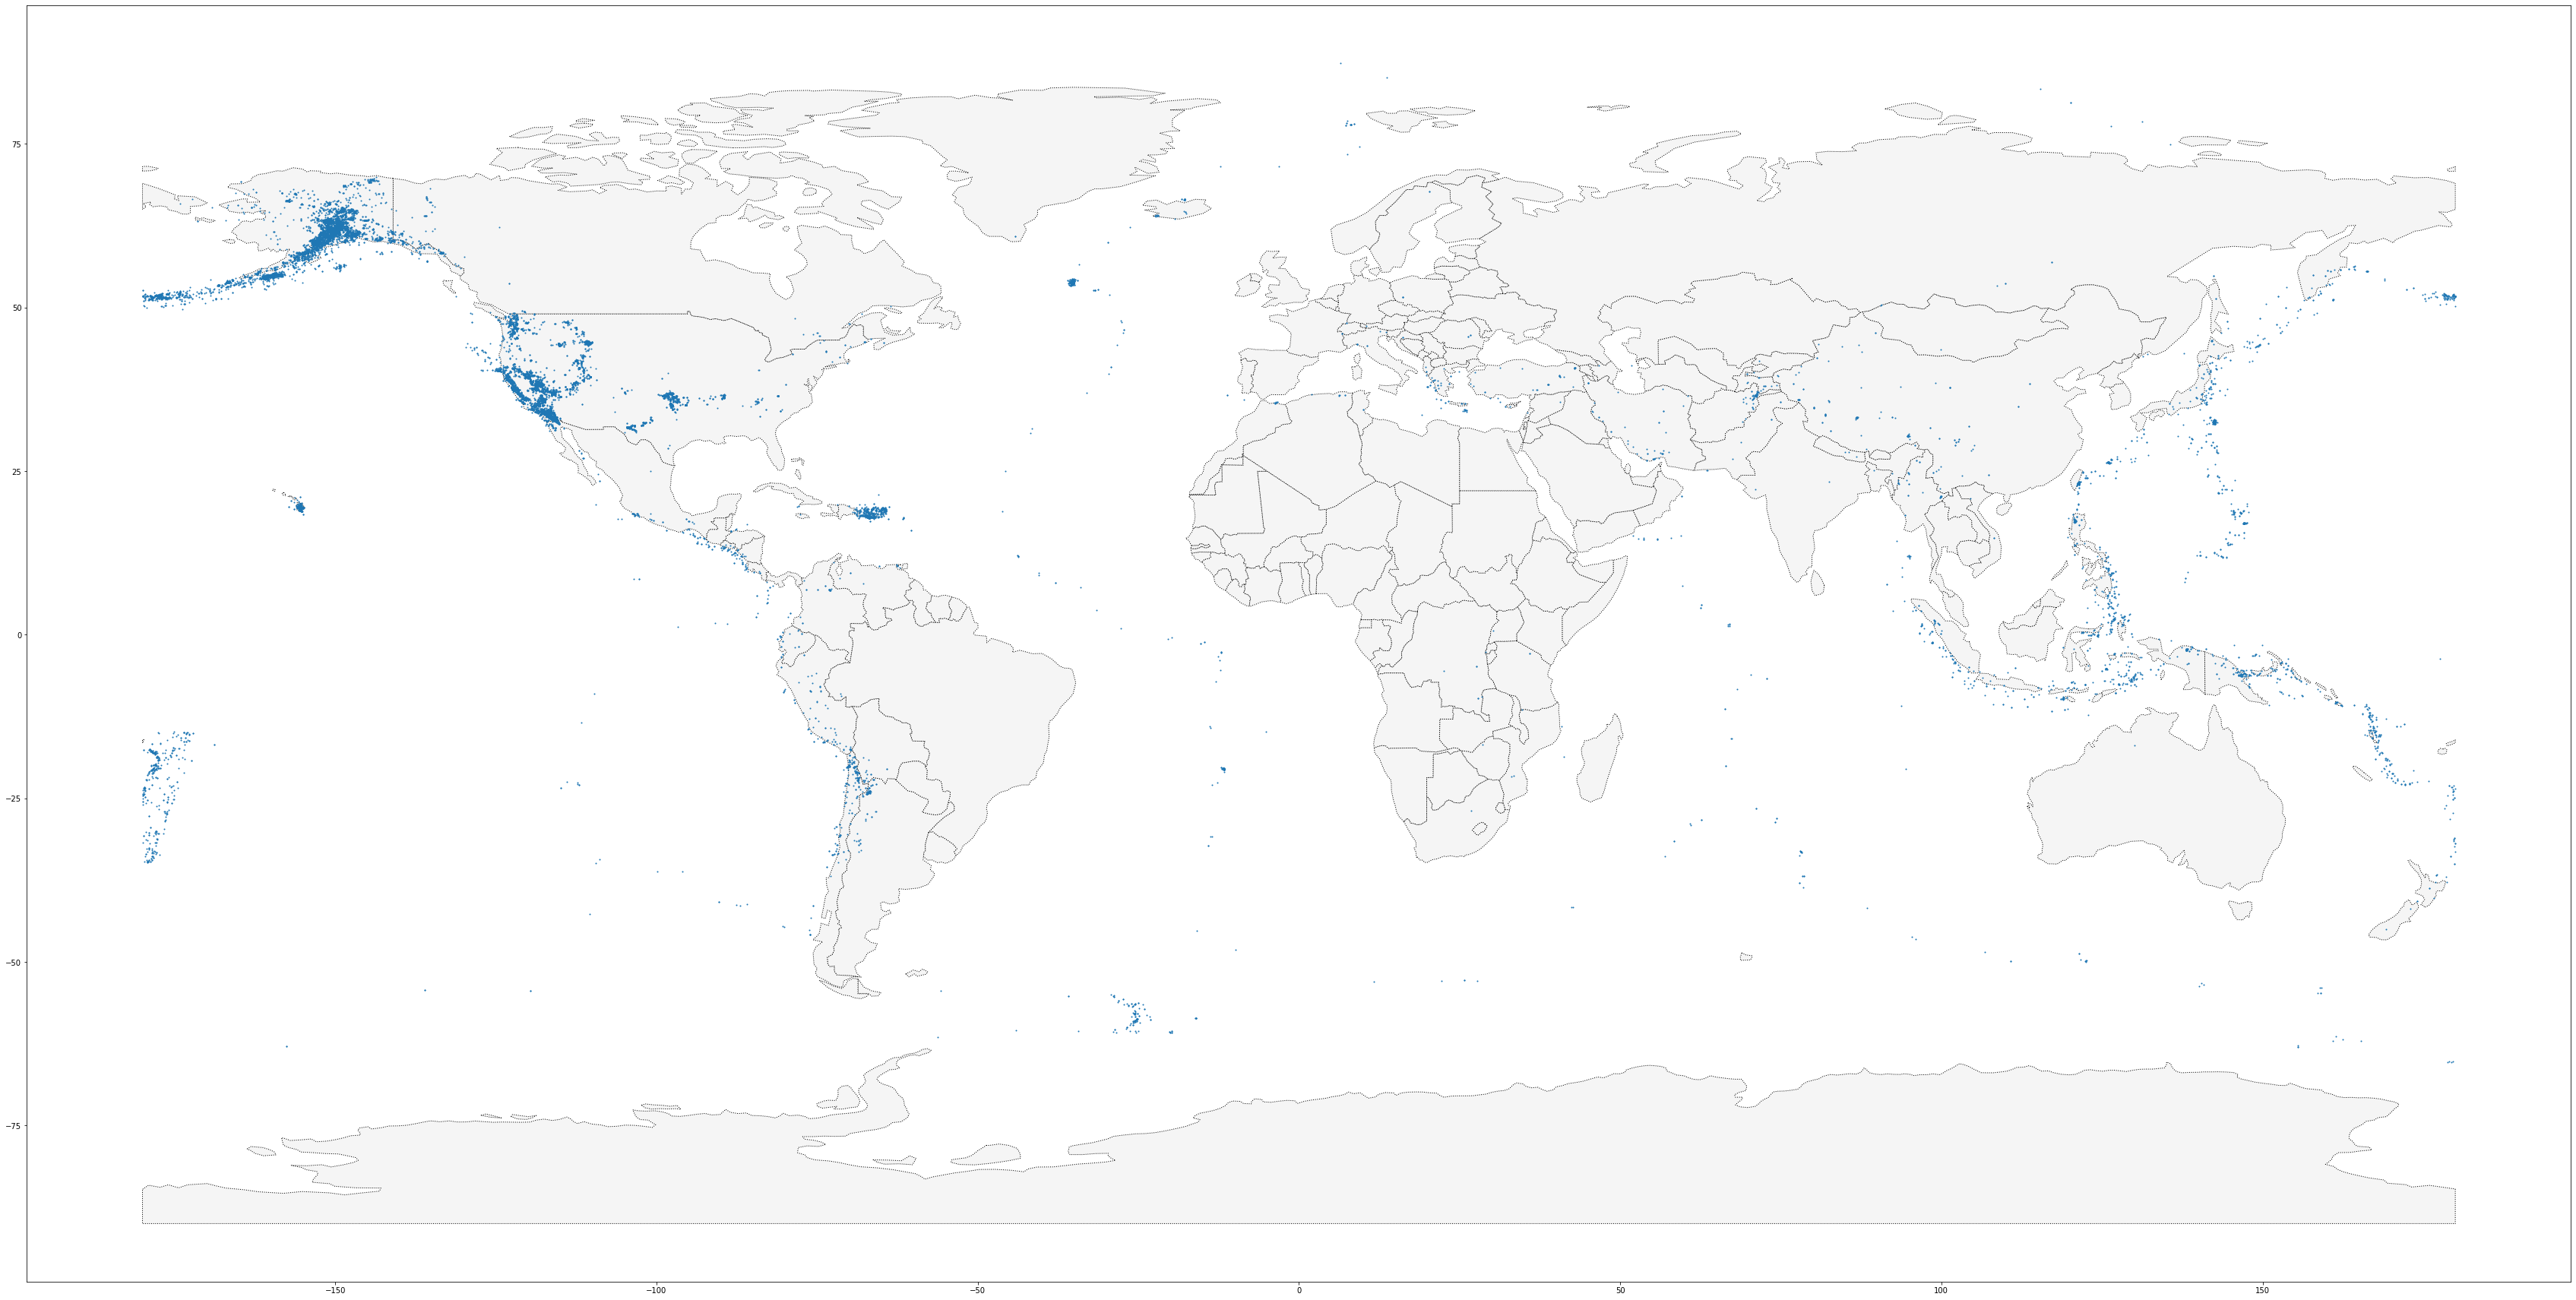

In [11]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [12]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


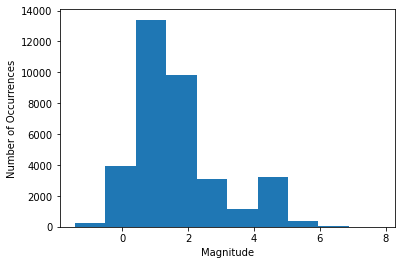

In [13]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

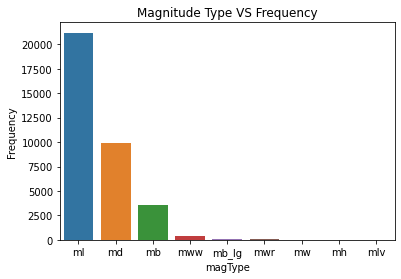

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [14]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [15]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

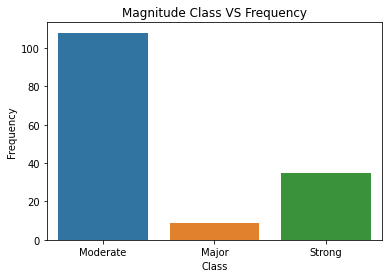

In [16]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

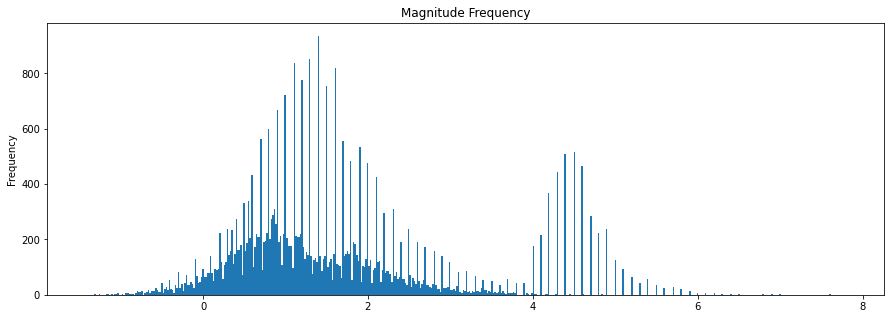

In [17]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.title('Magnitude Frequency')
plt.show()

In [18]:
threshold = 0.9
corr_matrix = df.corr() 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [19]:
percent = 30
df = df.dropna(axis=1, thresh=int(((100 - percent) / 100) * df.shape[0] + 1)) 

In [20]:
df = df.copy()
df['location'] = df.place.str.split(', ', expand=True)[1]
df.location.head() 

35244    Alaska
35243        CA
35242        CA
35241    Alaska
35240        CA
Name: location, dtype: object

In [21]:
print(f'Total locations: {df.location.nunique()}')

Total locations: 134


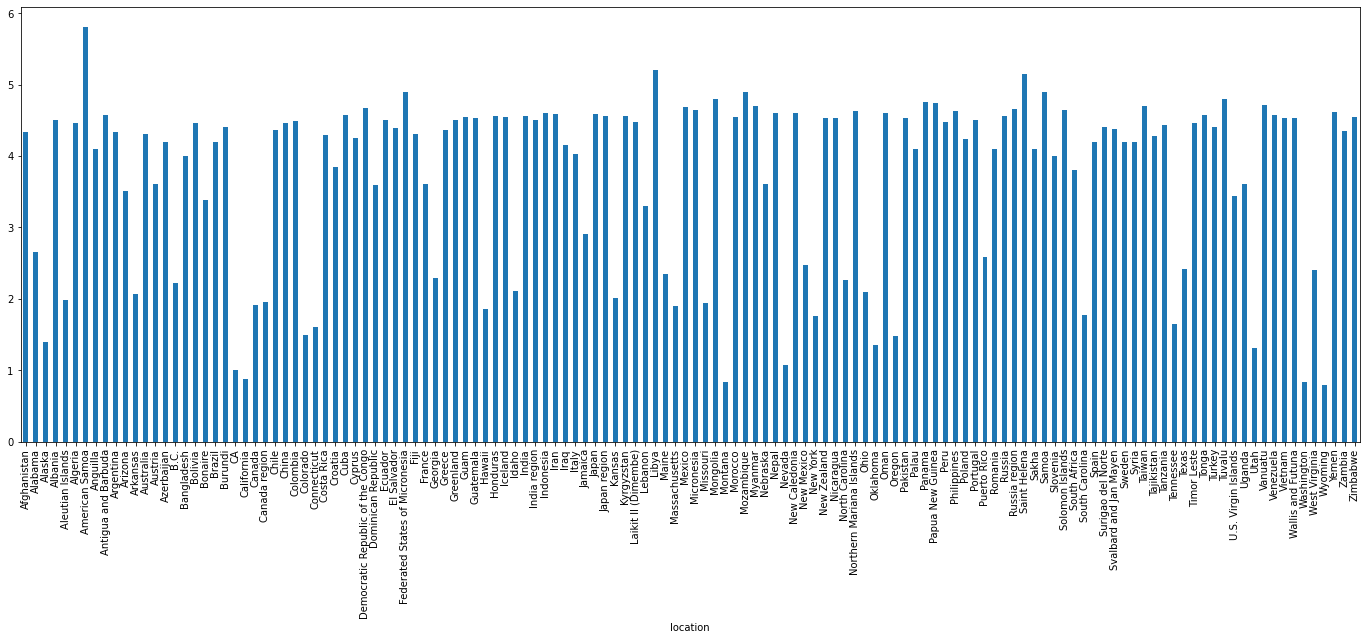

In [22]:
df.groupby(['location'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

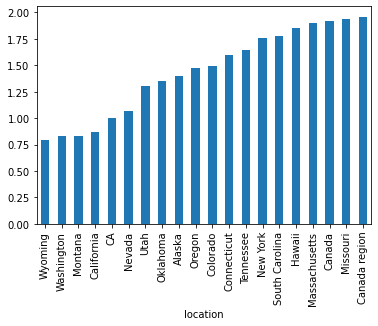

In [23]:
df.groupby(['location'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

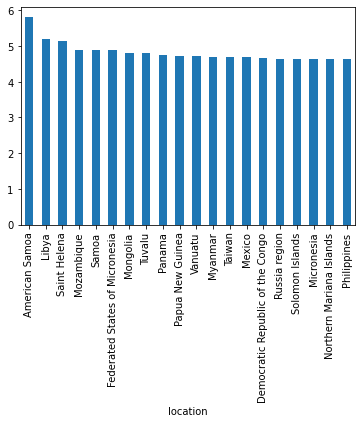

In [24]:
df.groupby(['location'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [25]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.time.dt.hour
    df['dayofweek'] = df.time.dt.dayofweek
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    df['dayofmonth'] = df.time.dt.day
    df['weekofyear'] = df.time.dt.isocalendar().week
    df['quarter'] = df.time.dt.quarter
    df['season'] = df.month % 12 // 3 + 1
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_lag'] = df.mag.shift(5)
    df['mag_10eq_lag'] = df.mag.shift(10)
    df['mag_15eq_lag'] = df.mag.shift(15)

    df['depth_5eq_lag'] = df.depth.shift(5)
    df['depth_10eq_lag'] = df.depth.shift(10)
    df['depth_15eq_lag'] = df.depth.shift(15)
    return df

def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5eq_avg'] = df.mag.rolling(window=5, center=False).mean()
    df['mag_10eq_avg'] = df.mag.rolling(window=10, center=False).mean()
    df['mag_15eq_avg'] = df.mag.rolling(window=15, center=False).mean()
    df['mag_5eq_min'] = df.mag.rolling(window=5, center=False).min()
    df['mag_10eq_min'] = df.mag.rolling(window=10, center=False).min()
    df['mag_15eq_min'] = df.mag.rolling(window=15, center=False).min()
    df['mag_5eq_max'] = df.mag.rolling(window=5, center=False).max()
    df['mag_10eq_max'] = df.mag.rolling(window=10, center=False).max()
    df['mag_15eq_max'] = df.mag.rolling(window=15, center=False).max()
    df['mag_5eq_std'] = df.mag.rolling(window=5, center=False).std()
    df['mag_10eq_std'] = df.mag.rolling(window=10, center=False).std()
    df['mag_15eq_std'] = df.mag.rolling(window=15, center=False).std()

    df['depth_5eq_avg'] = df.depth.rolling(window=5, center=False).mean()
    df['depth_10eq_avg'] = df.depth.rolling(window=10, center=False).mean()
    df['depth_15eq_avg'] = df.depth.rolling(window=15, center=False).mean()
    df['depth_5eq_min'] = df.depth.rolling(window=5, center=False).min()
    df['depth_10eq_min'] = df.depth.rolling(window=10, center=False).min()
    df['depth_15eq_min'] = df.depth.rolling(window=15, center=False).min()
    df['depth_5eq_max'] = df.depth.rolling(window=5, center=False).max()
    df['depth_10eq_max'] = df.depth.rolling(window=10, center=False).max()
    df['depth_15eq_max'] = df.depth.rolling(window=15, center=False).max()
    df['depth_5eq_std'] = df.depth.rolling(window=5, center=False).std()
    df['depth_10eq_std'] = df.depth.rolling(window=10, center=False).std()
    df['depth_15eq_std'] = df.depth.rolling(window=15, center=False).std()
    return df

data = []
for location in df.location.unique():
    temp = df.loc[df.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

df = pd.concat(data)

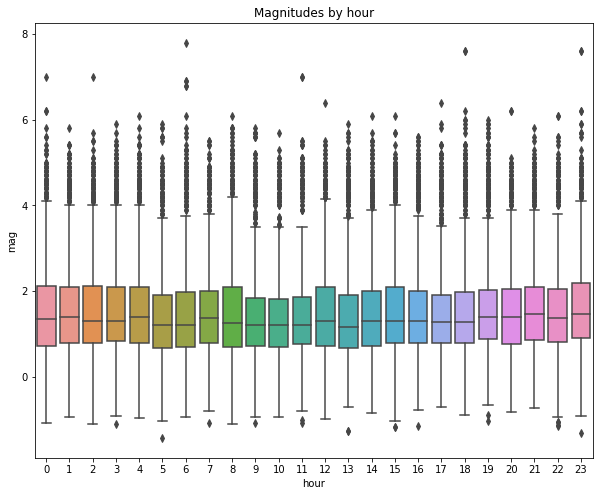

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

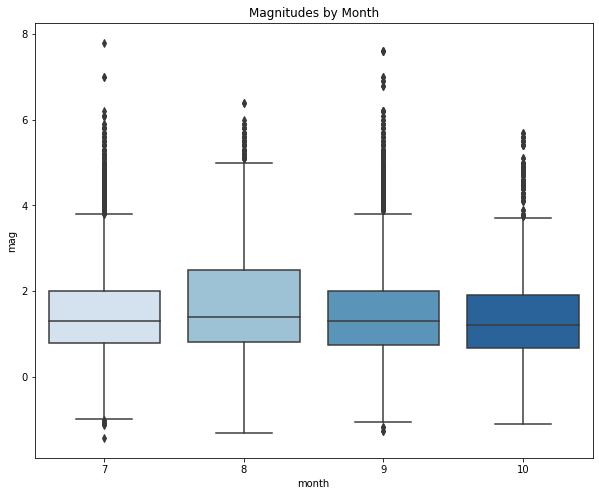

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [28]:
features = [
    'dayofyear',
    'hour',
    'dayofweek',
    'month',
    'season',
    'year',
    'mag_5eq_lag',
    'mag_10eq_lag',
    'mag_15eq_lag',
    'mag_5eq_avg',
    'mag_10eq_avg',
    'mag_15eq_avg',
    'mag_5eq_min',
    'mag_10eq_min',
    'mag_15eq_min',
    'mag_5eq_max',
    'mag_10eq_max',
    'mag_15eq_max',
    'mag_5eq_std',
    'mag_10eq_std',
    'mag_15eq_std',
    'depth_5eq_lag',
    'depth_10eq_lag',
    'depth_15eq_lag',
    'depth_5eq_avg',
    'depth_10eq_avg',
    'depth_15eq_avg',
    'depth_5eq_min',
    'depth_10eq_min',
    'depth_15eq_min',
    'depth_5eq_max',
    'depth_10eq_max',
    'depth_15eq_max',
    'depth_5eq_std',
    'depth_10eq_std',
    'depth_15eq_std',
    'latitude',
    'longitude',
]
cat_features = ['location']
target = 'mag'

In [29]:
date = '2022-09-25 00:00:00.000000+00:00'

df_train = df.loc[df.time < date]
df_test = df.loc[df.time >= date]

In [30]:
print(f'Test size: {len(df_test) / (len(df_test) + len(df_train))}')

Test size: 0.20542683682319415


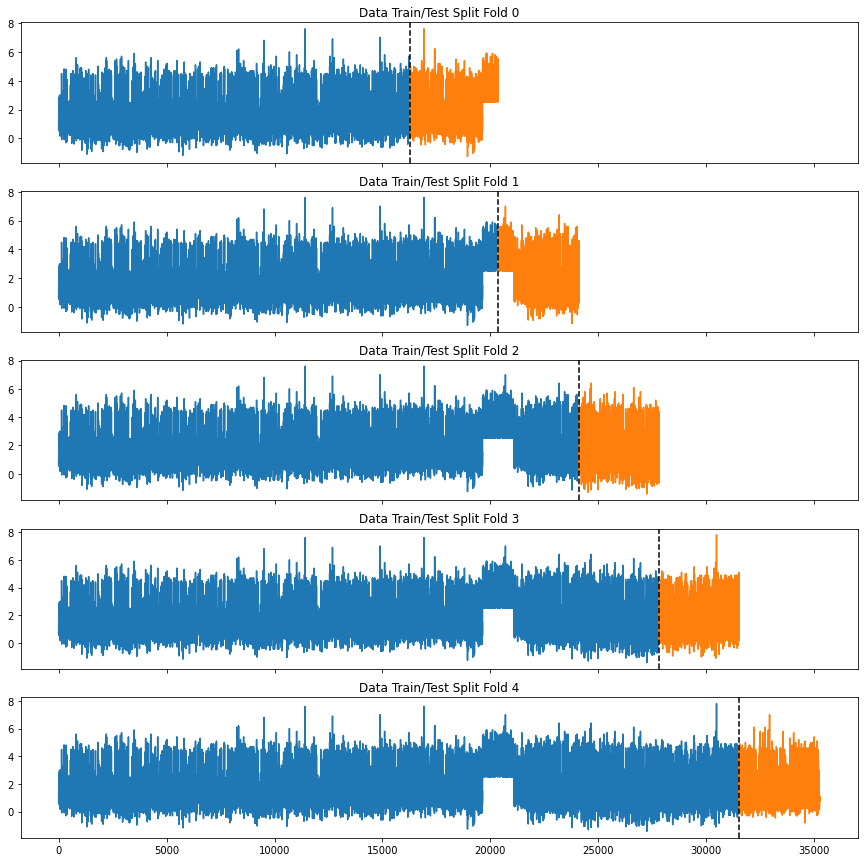

In [31]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [32]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50,
        cat_features=cat_features,
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

0:	learn: 1.1715721	test: 1.1715721	test1: 1.5351445	best: 1.5351445 (0)	total: 81.1ms	remaining: 1m 21s
100:	learn: 0.6884356	test: 0.6884356	test1: 0.7632562	best: 0.7632562 (100)	total: 2.81s	remaining: 25s
200:	learn: 0.5551174	test: 0.5551174	test1: 0.5532792	best: 0.5532792 (200)	total: 5.51s	remaining: 21.9s
300:	learn: 0.5144543	test: 0.5144543	test1: 0.5033324	best: 0.5033324 (300)	total: 8.14s	remaining: 18.9s
400:	learn: 0.4936838	test: 0.4936838	test1: 0.4862102	best: 0.4862102 (400)	total: 11.7s	remaining: 17.5s
500:	learn: 0.4777879	test: 0.4777879	test1: 0.4774414	best: 0.4774414 (500)	total: 14.9s	remaining: 14.9s
600:	learn: 0.4653617	test: 0.4653617	test1: 0.4722399	best: 0.4722399 (600)	total: 20.2s	remaining: 13.4s
700:	learn: 0.4541016	test: 0.4541016	test1: 0.4676925	best: 0.4676925 (700)	total: 23.1s	remaining: 9.87s
800:	learn: 0.4432932	test: 0.4432932	test1: 0.4641672	best: 0.4641672 (800)	total: 26.9s	remaining: 6.69s
900:	learn: 0.4336478	test: 0.4336478	tes

In [33]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.5505126767154127
Fold scores:[0.457214598957538, 0.5777886391710638, 0.6217369902141652, 0.5808819362750812, 0.5149412189592152]


In [34]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [35]:
grid = {
    'depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1500],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
462:	learn: 0.3416678	test: 0.4720465	best: 0.4720465 (462)	total: 16s	remaining: 35.8s
463:	learn: 0.3413749	test: 0.4717031	best: 0.4717031 (463)	total: 16s	remaining: 35.8s
464:	learn: 0.3411421	test: 0.4716910	best: 0.4716910 (464)	total: 16s	remaining: 35.7s
465:	learn: 0.3409961	test: 0.4716928	best: 0.4716910 (464)	total: 16.1s	remaining: 35.7s
466:	learn: 0.3407507	test: 0.4716615	best: 0.4716615 (466)	total: 16.1s	remaining: 35.7s
467:	learn: 0.3404623	test: 0.4717524	best: 0.4716615 (466)	total: 16.2s	remaining: 35.6s
468:	learn: 0.3400960	test: 0.4716914	best: 0.4716615 (466)	total: 16.2s	remaining: 35.6s
469:	learn: 0.3398963	test: 0.4717071	best: 0.4716615 (466)	total: 16.2s	remaining: 35.5s
470:	learn: 0.3396192	test: 0.4717542	best: 0.4716615 (466)	total: 16.2s	remaining: 35.5s
471:	learn: 0.3393697	test: 0.4716966	best: 0.4716615 (466)	total: 16.3s	remaining: 35.5s
472:	learn: 0.3392411	test: 0.4717306	best: 0.4716615 (

In [36]:
grid_search_result['params']

{'depth': 7, 'iterations': 1500, 'learning_rate': 0.05}

In [37]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8600904668889795
Mean Absolute Error: 0.3431579313259815
Root Mean Squared Error: 0.46065932939085086


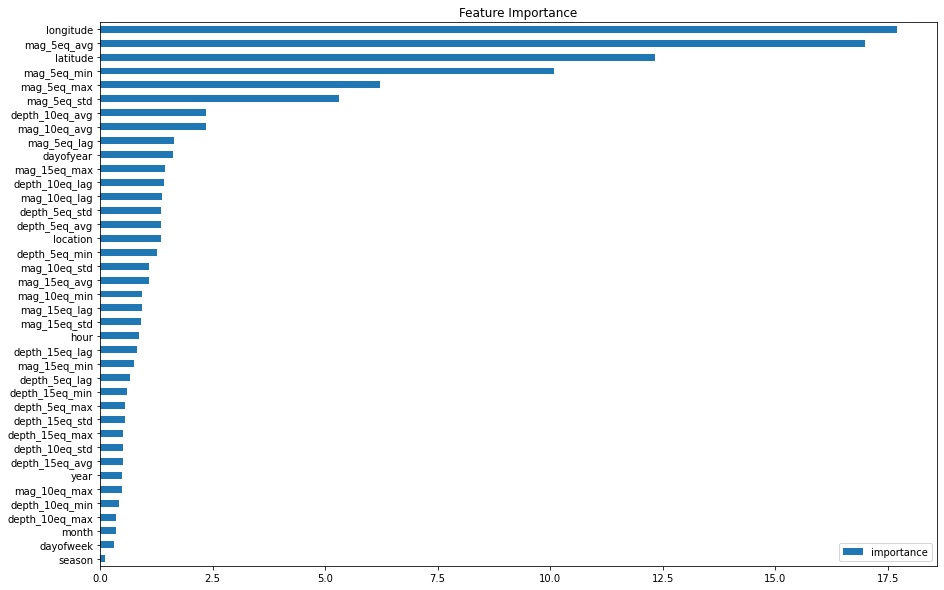

In [38]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

Accuracy of Model: 0.8284739098783382
Mean Absolute Error: 0.3439993347871313
Root Mean Squared Error: 0.47069590917519266


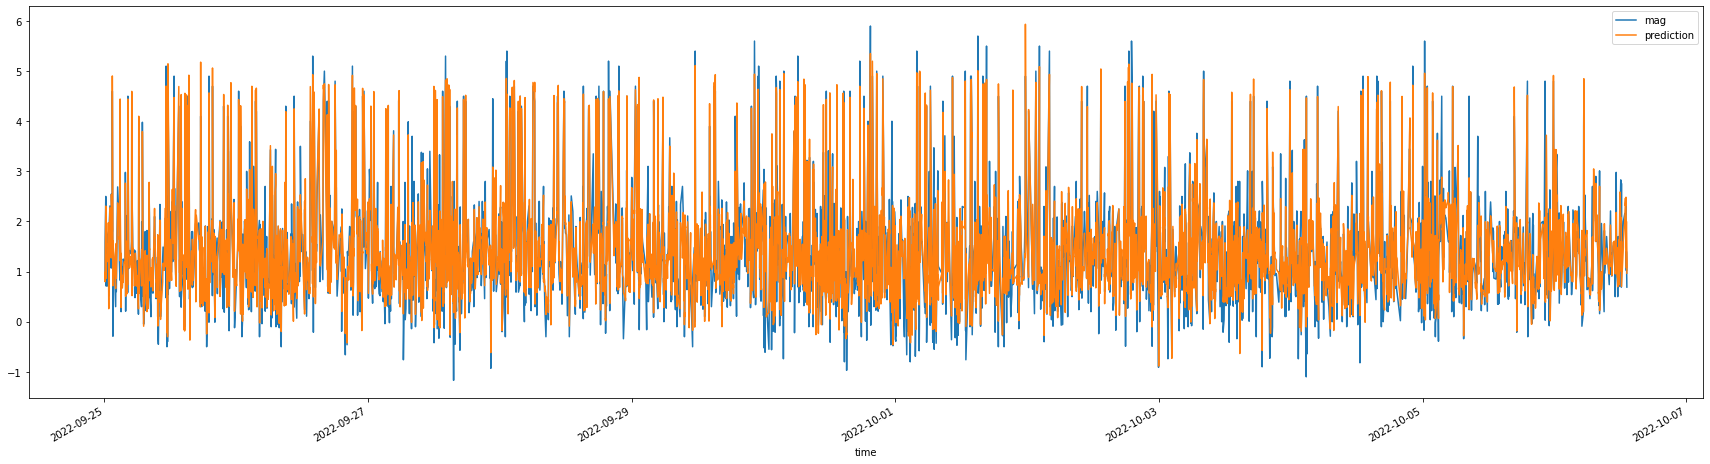

In [39]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'time': df_test.time, 'mag': df_test[target], 'prediction': prediction})
df_plot = df_plot.sort_values(by='time')
df_plot.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [40]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data.time = pd.to_datetime(live_data.time)
live_data['location'] = live_data.place.str.split(', ', expand=True)[1]
live_data = live_data[::-1]

In [41]:
data = []
for location in live_data.location.unique():
    temp = live_data.loc[live_data.location == location]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

live_data = pd.concat(data)

Accuracy of Model: 0.7559624263832296
Mean Absolute Error: 0.4160173783177272
Root Mean Squared Error: 0.5445814302642065


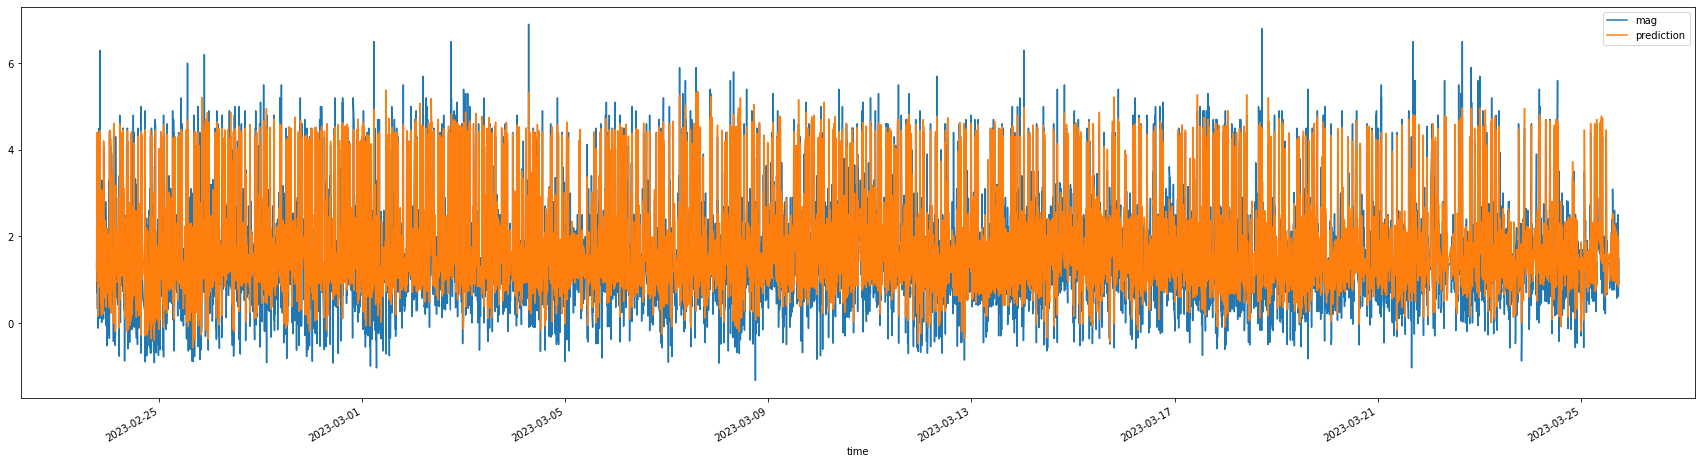

In [42]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction, 'time': live_data.time})
df_live = df_live.sort_values(by='time')
df_live.plot(figsize=(30, 8), x='time', y=['mag', 'prediction'])
plt.show()

In [43]:
model.save_model('./model.pickle')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')